# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
# assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

In [3]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0.5, 7.5, -0.5, 3.5]

x0, x1 = np.meshgrid(np.linspace(axes[0], axes[1], 500).reshape(-1, 1), np.linspace(axes[2], axes[3], 200).reshape(-1, 1))

X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

[0.5, 7.5, -0.5, 3.5]

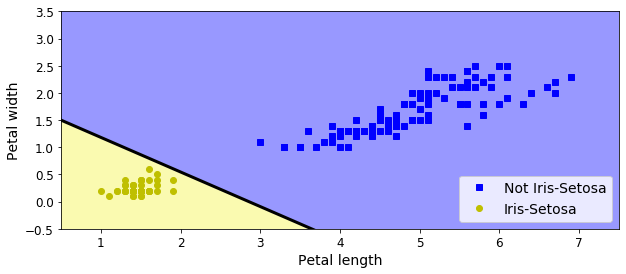

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y==1, 0], X[y==1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], 'k-', linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)


# Activation functions

In [5]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

def relu(z):
  return np.maximum(0, z)

def derivative(f, z, eps=1e-6):
  return (f(z + eps) - f(z - eps))/(2 * eps)

[-5, 5, -0.2, 1.2]

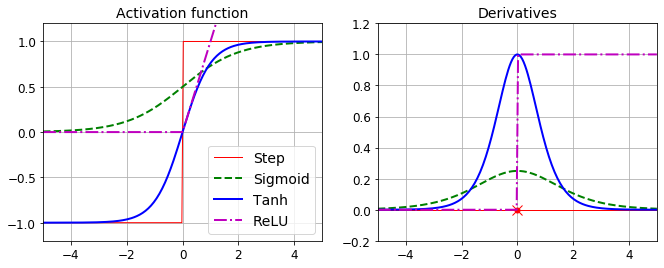

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc='lower right', fontsize=14)
plt.title('Activation function', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, 'ro', markersize=5)
plt.plot(0, 0, 'rx', markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, derivative(np.tanh, z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, derivative(relu, z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.title('Derivatives', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


In [7]:
def heaviside(z):
  return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
   return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

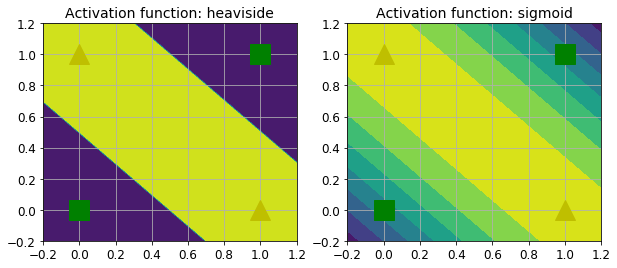

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: sigmoid', fontsize=14)
plt.grid(True)



# Building an Image Classifier

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'2.1.0'

In [11]:
keras.__version__

'2.2.4-tf'

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [13]:
X_train_full.shape

(60000, 28, 28)

In [14]:
X_train_full.dtype

dtype('uint8')

In [15]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

(-0.5, 27.5, 27.5, -0.5)

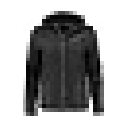

In [16]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')


In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [19]:
class_names[y_train[0]]

'Coat'

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

In [22]:
X_train.shape

(55000, 28, 28)

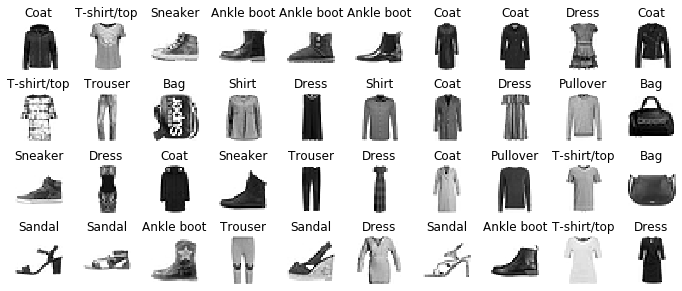

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
  for col in range(n_cols):
    idx = n_cols * row + col
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(X_train[idx], cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_train[idx]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)


In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


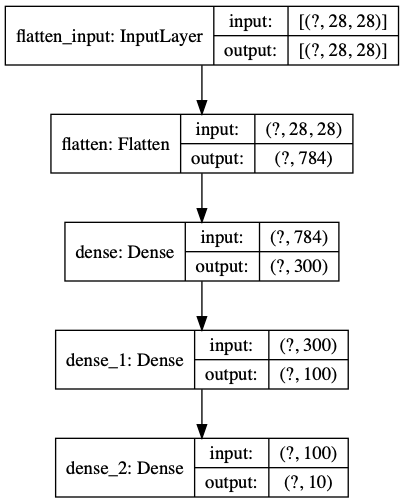

In [28]:
keras.utils.plot_model(model, 'my_mnist_model.png', show_shapes=True)

In [29]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [30]:
model.get_layer(hidden1.name) is hidden1

True

In [31]:
weights, biases = hidden1.get_weights()

In [32]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [33]:
weights.shape

(784, 300)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
biases.shape

(300,)

In [36]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.SGD(), metrics=[keras.metrics.sparse_categorical_accuracy])

In [37]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.7226 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.5073 - val_sparse_categorical_accuracy: 0.8320
Epoch 2/30
55000/55000 [==============================] - 2s 37us/sample - loss: 0.4844 - sparse_categorical_accuracy: 0.8321 - val_loss: 0.4541 - val_sparse_categorical_accuracy: 0.8478
Epoch 3/30
55000/55000 [==============================] - 2s 38us/sample - loss: 0.4414 - sparse_categorical_accuracy: 0.8464 - val_loss: 0.4373 - val_sparse_categorical_accuracy: 0.8508
Epoch 4/30
55000/55000 [==============================] - 2s 37us/sample - loss: 0.4129 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.4170 - val_sparse_categorical_accuracy: 0.8562
Epoch 5/30
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3927 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.3825 - val_sparse_categorical_accuracy: 0.8646
Epoch 6/30
55000

In [38]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss',
  'sparse_categorical_accuracy',
  'val_loss',
  'val_sparse_categorical_accuracy']}

In [39]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [40]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

(0, 1)

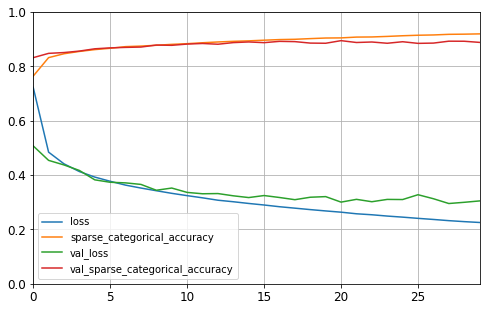

In [41]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)


In [42]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 20us/sample - loss: 0.3378 - sparse_categorical_accuracy: 0.8781


[0.33780701770782473, 0.8781]

In [43]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [44]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [45]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

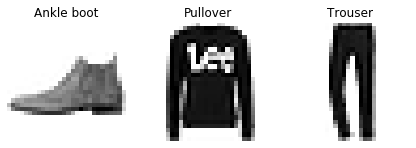

In [47]:
plt.figure(figsize=(7.2, 2.4))
for i, image in enumerate(X_new):
  plt.subplot(1, 3, i + 1)
  plt.imshow(image, cmap='binary', interpolation='nearest')
  plt.axis('off')
  plt.title(class_names[y_test[i]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)


# Regression MLP

In [48]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [49]:
housing = fetch_california_housing()

In [50]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
model = keras.models.Sequential([keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]), keras.layers.Dense(1)])
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 0s 38us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5004 - val_l

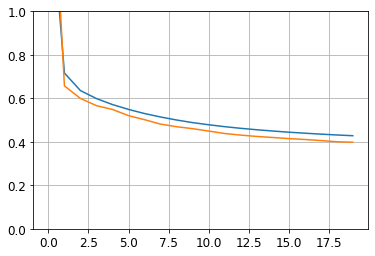

In [55]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [56]:
y_pred

array([[0.37310064],
       [1.6790789 ],
       [3.0817137 ]], dtype=float32)

# Functional API

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [60]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)


Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 43us/sample - loss: 1.2390 - val_loss: 0.6566
Epoch 2/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.6312 - val_loss: 0.6734
Epoch 3/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5886 - val_loss: 0.5574
Epoch 4/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5595 - val_loss: 0.5235
Epoch 5/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5361 - val_loss: 0.5011
Epoch 6/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5178 - val_loss: 0.5065
Epoch 7/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5016 - val_loss: 0.4699
Epoch 8/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4888 - val_loss: 0.4745
Epoch 9/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4772 - val_l

In [61]:
np.random.seed(42)
tf.random.set_seed(42)


In [62]:
input_A = keras.layers.Input(shape=[5], name='wide_output')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [63]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [64]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]


In [65]:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 45us/sample - loss: 1.8127 - val_loss: 2.1165
Epoch 2/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.6852 - val_loss: 0.6178
Epoch 3/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5965 - val_loss: 0.5600
Epoch 4/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5587 - val_loss: 0.5269
Epoch 5/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5321 - val_loss: 0.5185
Epoch 6/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5129 - val_loss: 0.4803
Epoch 7/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4959 - val_loss: 0.4689
Epoch 8/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4837 - val_loss: 0.4498
Epoch 9/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4734 - val_l

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [68]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [69]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 61us/sample - loss: 2.1346 - main_output_loss: 1.9194 - aux_output_loss: 4.0632 - val_loss: 2.9120 - val_main_output_loss: 2.2555 - val_aux_output_loss: 8.8088
Epoch 2/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.8954 - main_output_loss: 0.7048 - aux_output_loss: 2.6119 - val_loss: 1.4135 - val_main_output_loss: 0.6348 - val_aux_output_loss: 8.4172
Epoch 3/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.7400 - main_output_loss: 0.6077 - aux_output_loss: 1.9305 - val_loss: 1.3594 - val_main_output_loss: 0.5885 - val_aux_output_loss: 8.2925
Epoch 4/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6749 - main_output_loss: 0.5690 - aux_output_loss: 1.6264 - val_loss: 1.2789 - val_main_output_loss: 0.5611 - val_aux_output_loss: 7.7340
Epoch 5/20
11610/11610 [==============================] - 0s 33us/s

In [70]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 17us/sample - loss: 0.4656 - main_output_loss: 0.4165 - aux_output_loss: 0.9111


# The subclassing API

In [71]:
class WideAndDeepModel(keras.models.Model):
  def __init__(self, units=30, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)
    
  def call(self, inputs):
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return main_output, aux_output
  
model = WideAndDeepModel(30, activation='relu')

In [72]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10, validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 73us/sample - loss: 2.2719 - output_1_loss: 2.1554 - output_2_loss: 3.3117 - val_loss: 4.3377 - val_output_1_loss: 2.7732 - val_output_2_loss: 18.3999
Epoch 2/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.9891 - output_1_loss: 0.8653 - output_2_loss: 2.1062 - val_loss: 2.0073 - val_output_1_loss: 0.7581 - val_output_2_loss: 13.2427
Epoch 3/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.8320 - output_1_loss: 0.7303 - output_2_loss: 1.7468 - val_loss: 1.7215 - val_output_1_loss: 0.7114 - val_output_2_loss: 10.8051
Epoch 4/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.7658 - output_1_loss: 0.6760 - output_2_loss: 1.5726 - val_loss: 1.4708 - val_output_1_loss: 0.6454 - val_output_2_loss: 8.8938
Epoch 5/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.7223 - output_1_loss:

# Saving and Restoring

In [73]:
np.random.seed(42)
tf.random.set_seed(42)

In [74]:
model = keras.models.Sequential([
  keras.layers.Dense(30, activation='relu', input_shape=[8]),
  keras.layers.Dense(30, activation='relu'),
  keras.layers.Dense(1)
])

In [75]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 41us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4576 - val_l

In [76]:
model.save('my_keras_model.h5')

In [77]:
model = keras.models.load_model('my_keras_model.h5')

In [78]:
model.predict(X_new)

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [79]:
model.save_weights('my_keras_weights.ckpt')

In [80]:
model.load_weights('my_keras_weights.ckpt')

# Using Callbacks during Training

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [82]:
model = keras.models.Sequential([
  keras.layers.Dense(30, activation='relu', input_shape=[8]),
  keras.layers.Dense(30, activation='relu'),
  keras.layers.Dense(1)
])

In [83]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5')
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 42us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4576 - val_l

In [84]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4385 - val_loss: 0.4287
Epoch 2/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4319 - val_loss: 0.4117
Epoch 3/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4252 - val_loss: 0.3975
Epoch 4/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4199 - val_loss: 0.3943
Epoch 5/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4150 - val_loss: 0.3964
Epoch 6/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4110 - val_loss: 0.3907
Epoch 7/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4070 - val_loss: 0.3823
Epoch 8/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4036 - val_loss: 0.3786
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.400

In [85]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print('\nval/train: {:.2f}'.format(logs['val_loss'] / logs['loss']))

In [86]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
11136/11610 [===========================>..] - ETA: 0s - loss: 0.3253
val/train: 1.16
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3256 - val_loss: 0.3785


# TensorBoard

In [87]:
root_logdir = os.path.join(os.curdir, 'my_logs')

In [88]:
def get_run_logdir():
  import time
  run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
  return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_01_15-18_32_20'

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
model = keras.models.Sequential([
  keras.layers.Dense(30, activation='relu', input_shape=[8]),
  keras.layers.Dense(30, activation='relu'),
  keras.layers.Dense(1)
])

In [91]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [92]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 54us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/30
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/30
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4576 - val_l

In [93]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6060

In [95]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_01_15-18_35_17'

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
model = keras.models.Sequential([
  keras.layers.Dense(30, activation='relu', input_shape=[8]),
  keras.layers.Dense(30, activation='relu'),
  keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.05))

In [99]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 53us/sample - loss: 5.6341 - val_loss: 1.3205
Epoch 2/30
11610/11610 [==============================] - 0s 33us/sample - loss: 1.2704 - val_loss: 1.0757
Epoch 3/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.9370 - val_loss: 0.7769
Epoch 4/30
11610/11610 [==============================] - 0s 38us/sample - loss: 0.8854 - val_loss: 0.8254
Epoch 5/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.9501 - val_loss: 0.9415
Epoch 6/30
11610/11610 [==============================] - 0s 39us/sample - loss: 0.8283 - val_loss: 0.6111
Epoch 7/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.8095 - val_loss: 0.7394
Epoch 8/30
11610/11610 [==============================] - 1s 45us/sample - loss: 1.1857 - val_loss: 1.0356
Epoch 9/30
11610/11610 [==============================] - 0s 43us/sample - loss: 0.8920 - val_l

In [100]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [101]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(lr=learning_rate)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [104]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [105]:
keras_reg.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 43us/sample - loss: 1.1399 - val_loss: 24.4309
Epoch 2/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.7393 - val_loss: 3.2896
Epoch 3/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5374 - val_loss: 0.6080
Epoch 4/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4796 - val_loss: 0.4532
Epoch 5/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4536 - val_loss: 0.4221
Epoch 6/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4373 - val_loss: 0.4144
Epoch 7/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4256 - val_loss: 0.4025
Epoch 8/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4178 - val_loss: 0.3938
Epoch 9/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.41

In [106]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3464


In [107]:
y_pred = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3464


In [108]:
y_pred = keras_reg.predict(X_new)

In [109]:
np.random.seed(42)
tf.random.set_seed(42)

In [111]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
  'n_hidden': [0, 1, 2, 3],
  'n_neurons': np.arange(1, 100),
  'learning_rate': reciprocal(3e-4, 3e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.00037192261022352417, n_hidden=3, n_neurons=80 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 1s 65us/sample - loss: 3.8585 - val_loss: 8.5464
Epoch 2/100
7740/7740 [==============================] - 0s 34us/sample - loss: 1.9973 - val_loss: 7.1943
Epoch 3/100
7740/7740 [==============================] - 0s 37us/sample - loss: 1.3600 - val_loss: 4.5307
Epoch 4/100
7740/7740 [==============================] - 0s 41us/sample - loss: 1.0696 - val_loss: 2.9063
Epoch 5/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8998 - val_loss: 1.7880
Epoch 6/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7907 - val_loss: 1.3361
Epoch 7/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.7223 - val_loss: 1.0208
Epoch 8/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.6781 - val_loss: 0.8291
Epoch 9/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6484 - val_loss: 0.7218
Epoch 10/100
7740/7740 [==============================] - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.2s remaining:    0.0s


7740/7740 [==============================] - 1s 73us/sample - loss: 2.9814 - val_loss: 10.3257
Epoch 2/100
7740/7740 [==============================] - 0s 52us/sample - loss: 1.1181 - val_loss: 13.1010
Epoch 3/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.8495 - val_loss: 11.5890
Epoch 4/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.7572 - val_loss: 9.7864
Epoch 5/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7101 - val_loss: 8.2871
Epoch 6/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6804 - val_loss: 7.1318
Epoch 7/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6584 - val_loss: 5.9640
Epoch 8/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.6397 - val_loss: 5.2104
Epoch 9/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6231 - val_loss: 4.4083
Epoch 10/100
7740/7740 [==============================]

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.4min finished


11610/11610 [==============================] - 1s 48us/sample - loss: 0.7127 - val_loss: 4.3353
Epoch 2/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4846 - val_loss: 1.3186
Epoch 3/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4295 - val_loss: 6.0342
Epoch 4/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4229 - val_loss: 0.9433
Epoch 5/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3971 - val_loss: 1.5476
Epoch 6/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3824 - val_loss: 0.3488
Epoch 7/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3655 - val_loss: 0.3478
Epoch 8/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3602 - val_loss: 0.3391
Epoch 9/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3547 - val_loss: 0.3287
Epoch 10/100
11610/11610 [==============

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f97608d2ed0>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9789d367d0>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_trai

In [112]:
rnd_search_cv.best_params_

{'learning_rate': 0.01573990360087585, 'n_hidden': 2, 'n_neurons': 21}

In [113]:
rnd_search_cv.best_score_

-0.32837737947830753

In [114]:
rnd_search_cv.best_estimator_

In [115]:
rnd_search_cv.score(X_test, y_test)

5160/5160 [==============================] - 0s 16us/sample - loss: 0.3269


-0.3268537571379381

In [116]:
model = rnd_search_cv.best_estimator_.model
model

In [117]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 17us/sample - loss: 0.3269


0.3268537571379381